In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
tr_data = pd.read_csv('../input/train.csv')
te_data = pd.read_csv('../input/test.csv')
print('train shape: {}'.format(tr_data.shape))
print('test shape: {}'.format(te_data.shape))
print('train data head:')
tr_data.head()


train shape: (42000, 785)
test shape: (28000, 784)
train data head:


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


as we can see the data has 785 columns which are 28*28 pixels +1 labels column (which will only appear in the train data)

In [3]:
print('test data head:')
te_data.head()

test data head:


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


as usual lets separate our training data from the labels

In [4]:
X_train = tr_data.iloc[:,1:].values.astype('float32') # all pixel values
y_train = tr_data.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = te_data.values.astype('float32')

In [9]:
%%time
import xgboost as xgb
params = {'objective':'multi:softprob',
                    'learning_rate':0.2,
                    'subsample':0.8,
                    'colsample_bytree':0.9,
                    'colsample_bylevel':0.7,
                    'max_depth':5,
                    'nthread':4,
                    'eval_metric':'mlogloss',
                    'n_estimators':100,
                    'num_class':10,
                    'seed':1234}
bst_cv = xgb.cv(params=params,dtrain=xgb.DMatrix(X_train,label=y_train),verbose_eval=2,
                nfold=5,early_stopping_rounds=20,num_boost_round=30)


[0]	train-mlogloss:1.69801+0.0032127	test-mlogloss:1.71193+0.00702032
[2]	train-mlogloss:1.1779+0.00332384	test-mlogloss:1.20553+0.00647845
[4]	train-mlogloss:0.883198+0.00420416	test-mlogloss:0.917629+0.00597328
[6]	train-mlogloss:0.688887+0.00174742	test-mlogloss:0.7287+0.00747862
[8]	train-mlogloss:0.554026+0.00224428	test-mlogloss:0.598385+0.00718724
[10]	train-mlogloss:0.4555+0.00216103	test-mlogloss:0.503589+0.00699719
[12]	train-mlogloss:0.38099+0.00226145	test-mlogloss:0.432329+0.00688715
[14]	train-mlogloss:0.323871+0.00305608	test-mlogloss:0.378545+0.00634408
[16]	train-mlogloss:0.278592+0.00306677	test-mlogloss:0.335212+0.0061126
[18]	train-mlogloss:0.24304+0.00233473	test-mlogloss:0.302117+0.00646911
[20]	train-mlogloss:0.214098+0.00200352	test-mlogloss:0.275589+0.00671574
[22]	train-mlogloss:0.190429+0.00209449	test-mlogloss:0.253872+0.00635668
[24]	train-mlogloss:0.170813+0.00181613	test-mlogloss:0.236119+0.00625868
[26]	train-mlogloss:0.153368+0.00155479	test-mlogloss:0.

In [13]:
%%time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,KFold
knn4 = KNeighborsClassifier(n_jobs=-1,n_neighbors=4)
print(cross_val_score(cv=5,estimator=knn4,X=X_train,y=y_train))

CPU times: user 1h 50s, sys: 2.41 s, total: 1h 52s
Wall time: 16min 8s


In [19]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFECV
gbc = XGBClassifier(objective='multi:softprob',
                    learning_rate=0.2,
                    subsample=0.9,
                    colsample_bytree=1,
                    colsample_bylevel=1,
                    max_depth=3,
                    nthread=4,
                    n_estimators=10,
                    seed=1234)
rfecv = RFECV(estimator=gbc, step=5, cv=5, scoring='neg_log_loss')
rfecv.fit(X_train, y_train)
print("Optimal number of features :{}".format(rfecv.n_features_))
print('rfecv rankings: {}'.format(rfecv.ranking_))

ValueError: Found array with dim 4. Estimator expected <= 2.

now lets try to use only these features for prediction:

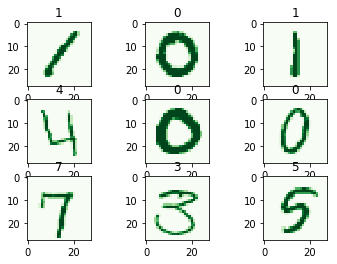

In [7]:
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('Greens'))
    plt.title(y_train[i])

In [ ]:
# add code here to use only selected features



now lets see what NN can get on this data, 
but first we'll have to preprocess it:

In [8]:
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train-train_mean)/train_std
X_text = (X_test-train_mean)/train_std # pay attention that we normalize by train data and not by test data

as we learned, in classification tasks the output of each node in the last layer of the network represent the probability
for each number - this means that we have to one-hot-encode each of the classes so that we will be able to compare the probability for each of the digits.

luckily, keras can easily do that for us:

In [13]:
from keras.utils.np_utils import to_categorical
OHE_y_train = to_categorical(y_train)
num_classes = OHE_y_train.shape[1]
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)

In [20]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 5s - loss: 0.4254 - acc: 0.8734 - val_loss: 0.3148 - val_acc: 0.9082
Epoch 2/10
33600/33600 [==============================] - 5s - loss: 0.3070 - acc: 0.9126 - val_loss: 0.3208 - val_acc: 0.9055
Epoch 3/10
33600/33600 [==============================] - 5s - loss: 0.2932 - acc: 0.9171 - val_loss: 0.2999 - val_acc: 0.9161
Epoch 4/10
33600/33600 [==============================] - 5s - loss: 0.2843 - acc: 0.9203 - val_loss: 0.29

In [34]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import Adadelta
model.compile(optimizer=Adadelta(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 5s - loss: 0.6076 - acc: 0.8153 - val_loss: 0.3653 - val_acc: 0.8938
Epoch 2/10
33600/33600 [==============================] - 5s - loss: 0.3409 - acc: 0.9008 - val_loss: 0.3213 - val_acc: 0.9088
Epoch 3/10
33600/33600 [==============================] - 5s - loss: 0.3111 - acc: 0.9092 - val_loss: 0.3096 - val_acc: 0.9107
Epoch 4/10
33600/33600 [==============================] - 5s - loss: 0.2965 - acc: 0.9147 - val_loss: 0.29

In [36]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_23 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 10)                7850      
_________________________________________________________________
dense_47 (Dense)             (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 6s - loss: 0.5244 - acc: 0.8434 - val_loss: 0.3413 - val_acc: 0.9029
Epoch 2/10
33600/33600 [==============================] - 5s - loss: 0.3217 - acc: 0.9062 - val_loss: 0.3216 - val_acc: 0.9055
Epoch 3/10
33600/33600 [==============================] - 6s - loss: 0.2917 - acc: 0.9158 - val_loss:

In [22]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(200, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 200)               157000    
_________________________________________________________________
dense_16 (Dense)             (None, 10)                2010      
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 5s - loss: 0.2623 - acc: 0.9215 - val_loss: 0.1536 - val_acc: 0.9531
Epoch 2/10
33600/33600 [==============================] - 5s - loss: 0.1174 - acc: 0.9652 - val_loss: 0.1241 - val_acc: 0.9654
Epoch 3/10
33600/33600 [==============================] - 5s - loss: 0.0824 - acc: 0.9746 - val_l

In [28]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 6s - loss: 0.2908 - acc: 0.9119 - val_loss: 0.1439 - val_acc: 0.9565
Epoch 2/10
33600/33600 [==============================] - 6s - loss: 0.1503 - acc: 0.9570 - 

In [33]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import Adadelta
model.compile(optimizer=Adadelta(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 300)               235500    
_________________________________________________________________
dropout_14 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________
Train on 33600 samples, validate on 8400 samples
Epoch 1/10
33600/33600 [==============================] - 6s - loss: 0.3639 - acc: 0.8891 - val_loss: 0.1885 - val_acc: 0.9439
Epoch 2/10
33600/33600 [==============================] - 6s - loss: 0.1741 - acc: 0.9482 - 

In [32]:
model= Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10, activation='softmax'))

model.summary()
from keras.optimizers import Adadelta
model.compile(optimizer=Adadelta(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])


model.fit(X_train,OHE_y_train,validation_split=0.2,shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 200)               157000    
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 20)                4020      
_________________________________________________________________
dropout_13 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 10)                210       
Total params: 161,230
Trainable params: 161,230
Non-trainable params: 0
_________________________________________________________________
Trai

In [38]:
import PIL
# img = cv2.imread('../input/scr_written_digits_1.png')
# img

ImportError: No module named 'PIL'